0.87299545699053582


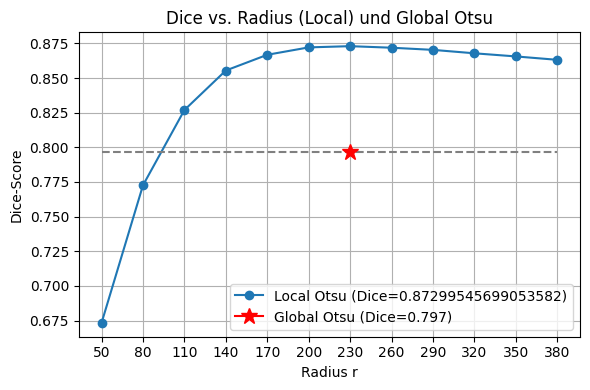

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
from skimage.filters import threshold_local, threshold_otsu
from src.find_image import find_and_load_image

def dice_score(mask, gt):
    inter = np.logical_and(mask, gt).sum()
    return 2 * inter / (mask.sum() + gt.sum())

# 1) Bilder laden
img      = find_and_load_image("dna-49.png",    as_gray=True)
gt       = find_and_load_image("49.png", as_gray=True)
img_u8   = img_as_ubyte(img)
gt_mask  = gt > 0  

# 2) Globaler Otsu einmalig
t_glob   = threshold_otsu(img_u8)
mask_glob= img_u8 > t_glob
dice_glob= dice_score(mask_glob, gt_mask)

# 3) Lokales Otsu für verschiedene Radien
#radii = list(range(300, 1400, 100))
radii = list(range(50, 400, 30))
scores_loc = []
for r in radii:
    block = 2*r+1 if r>0 else 3
    t_loc = threshold_local(img_u8, block, method="gaussian")
    mask_loc = img_u8 > t_loc
    scores_loc.append(dice_score(mask_loc, gt_mask))

print(f"{max(scores_loc):.17f}")

# 4) Plot beider Kurven
plt.figure(figsize=(6,4))
plt.plot(radii, scores_loc, "-o", label=f"Local Otsu (Dice={max(scores_loc):.17f})")
plt.plot([radii[0], radii[-1]], [dice_glob, dice_glob], "--", color="gray")
# oder als einziger Stern:
plt.plot(radii[len(radii)//2], dice_glob, marker="*", color="red",
         markersize=12, label=f"Global Otsu (Dice={dice_glob:.3f})")

plt.title("Dice vs. Radius (Local) und Global Otsu")
plt.xlabel("Radius r")
plt.ylabel("Dice-Score") 
plt.xticks(radii)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# eval_all_images.py

import os
from pathlib import Path
import numpy as np
from skimage import io, img_as_ubyte
from skimage.filters import threshold_local, threshold_otsu
from itertools import chain
import csv

def dice_score(mask, gt):
    """Dice‐Koeffizient zwischen zwei Bool‐Masken."""
    inter = np.logical_and(mask, gt).sum()
    return 2 * inter / (mask.sum() + gt.sum())

from pathlib import Path
            

def eval_best_radius(img_u8, gt_mask, radii):
    best_r, best_score = None, -1.0
    for r in radii:
        block = 2*r + 1 if r>0 else 3
        t_loc = threshold_local(img_u8, block, method="gaussian")
        mask_loc = img_u8 > t_loc
        score = dice_score(mask_loc, gt_mask)
        if score > best_score:
            best_score, best_r = score, r
    return best_r, best_score

from src.imread_all import  load_nih3t3_images, load_n2dh_gowt1_images, load_n2dl_hela_images

def main():
    datasets = [
            ("NIH3T3", load_nih3t3_images),
            ("N2DH-GOWT1", load_n2dh_gowt1_images),
            ("N2DL-HeLa", load_n2dl_hela_images),]
    radii    = list(range(50, 100, 50))

    results = {}
    for dataset_name, loader in datasets:
        dataset = dataset_name
        imgs, gts, img_paths, gt_paths = loader()
        for  img, gt, img_path, gt_path in zip(imgs, gts, img_paths, gt_paths):
            
             # Lade Original und GT
            img_u8 = img_as_ubyte(img)
            gt_mask = gt > 0

            filename = os.path.basename(img_path)
            # best radius und score
            r, score = eval_best_radius(img_u8, gt_mask, radii)

            results.setdefault(dataset, []).append((filename, r, score))

    # Ausgabe
    for ds, items in results.items():
        print(f"\n=== Dataset: {ds} ===")
        for name, r, s in items:
            print(f"  {name:20s} → best radius = {r:3d}, Dice = {s:.4f}")

   
    # Angenommen, du hast ein Dict:
     # results = { "N2DH-GOWT1": [("t01.tif", 10), ("t21.tif", 20)], ... }

    with open("best_radius2.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Dataset", "Bild", "BestRadius", "DiceScore"])
        for ds, items in results.items():
            for name, radius, score in items:
                writer.writerow([ds, name, radius, score])
        
    

if __name__ == "__main__":
    main()




=== Dataset: NIH3T3 ===
  dna-0.png            → best radius =  50, Dice = 0.4303
  dna-1.png            → best radius =  50, Dice = 0.4596
  dna-26.png           → best radius =  50, Dice = 0.5440
  dna-27.png           → best radius =  50, Dice = 0.5740
  dna-28.png           → best radius =  50, Dice = 0.5278
  dna-29.png           → best radius =  50, Dice = 0.4684
  dna-30.png           → best radius =  50, Dice = 0.5782
  dna-31.png           → best radius =  50, Dice = 0.6322
  dna-32.png           → best radius =  50, Dice = 0.5270
  dna-33.png           → best radius =  50, Dice = 0.4897
  dna-37.png           → best radius =  50, Dice = 0.4957
  dna-40.png           → best radius =  50, Dice = 0.5023
  dna-42.png           → best radius =  50, Dice = 0.4678
  dna-44.png           → best radius =  50, Dice = 0.6743
  dna-45.png           → best radius =  50, Dice = 0.5331
  dna-46.png           → best radius =  50, Dice = 0.4875
  dna-47.png           → best radius =  50, Dic

Note: you may need to restart the kernel to use updated packages.
      Dataset  BestRadius
0  N2DH-GOWT1      1550.0
1   N2DL-HeLa       300.0
2      NIH3T3       300.0


/var/folders/wd/pl9k9xs93l9bzvhwc5zs9b4m0000gn/T/ipykernel_93695/2450851952.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


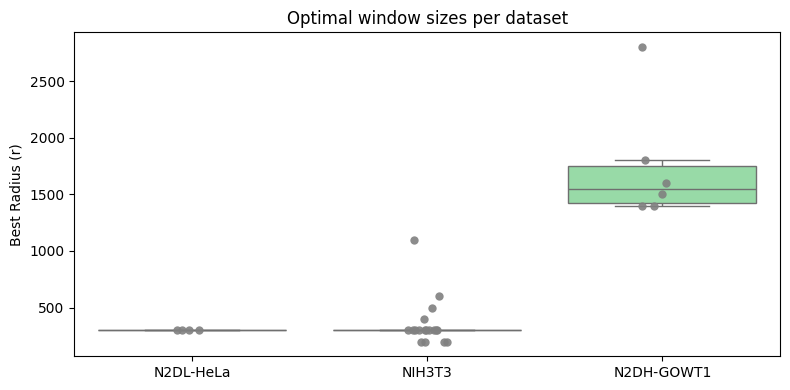

In [2]:
%pip install seaborn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys


# CSV einlesen
df = pd.read_csv("output/best_radius.csv")

df2 = mean_radius = df.groupby("Dataset")["BestRadius"].median().reset_index()
print(df2)
# Größe des Plots
plt.figure(figsize=(8, 4))

# Boxplot mit Seaborn
sns.boxplot(
    x="Dataset",
    y="BestRadius",
    data=df,
    palette="pastel",    # dezente Farbpalette
    showfliers=False      # Ausreißerpunkte zeigen
)

# Optional: einzelne Werte zusätzlich als Jitter-Punkte
sns.stripplot(
    x="Dataset",
    y="BestRadius",
    data=df,
    color="gray",
    alpha=0.9,
    jitter=True,
    size=6
)

# Titel und Achsen beschriften
plt.title("Optimal window sizes per dataset")
plt.ylabel("Best Radius (r)")
plt.xlabel("")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import sys

# add project root
script_dir = os.getcwd()
project_root = os.path.abspath(script_dir)

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.Dice_Score import dice_score
from src.Otsu_Local import local_otsu_package

def find_best_radius_for_datasets_package(
    datasets=None,
    radii=None,
    save_csv_path=None
):
    """
    Berechnet für alle Bilder der angegebenen Datensätze den besten lokalen Otsu-Radius.

    Args:
        datasets (list of tuples, optional): Liste von (dataset_name, loader_funktion).
            Wenn None, werden NIH3T3, N2DH-GOWT1, N2DL-HeLa geladen.
        radii (list of int, optional): Liste der zu testenden Radien. Defaults to [1,3,...,49].
        save_csv_path (str, optional): Falls angegeben, wird eine CSV mit den Ergebnissen gespeichert.

    Returns:
        list of dict: Liste mit Ergebnissen für alle Bilder (Dataset, Image, BestRadius, BestDice).
    """
    if radii is None:
        radii = list(range(1, 3, 2))

    if datasets is None:
        from src.imread_all import load_n2dh_gowt1_images, load_n2dl_hela_images, load_nih3t3_images
        datasets = [
            ("NIH3T3", load_nih3t3_images),
            ("N2DH-GOWT1", load_n2dh_gowt1_images),
            ("N2DL-HeLa", load_n2dl_hela_images),
        ]

    all_results = []

    for dataset_name, loader in datasets:
        print(f"\n--- Processing dataset: {dataset_name} ---")
        imgs, gts, img_paths, gt_paths = loader()

        for img, gt, img_path in tqdm(zip(imgs, gts, img_paths), total=len(imgs), desc=f"Images in {dataset_name}"):
            best_dice = -1
            best_radius = None

            for r in radii:
                try:
                    local_thresh = local_otsu_package(img, radius=r)
                    mask = img > local_thresh
                    dice = dice_score(mask, gt)
                except Exception as e:
                    print(f"[WARN] Fehler bei Bild {img_path} mit Radius {r}: {e}")
                    continue

                if dice > best_dice:
                    best_dice = dice
                    best_radius = r

            all_results.append({
                "Dataset": dataset_name,
                "Image": os.path.basename(img_path),
                "BestRadius": best_radius,
                "BestDice": best_dice
            })

    # Ergebnisse ausgeben
    for result in all_results:
        print(f"{result['Dataset']}/{result['Image']}: bester Radius = {result['BestRadius']}, Dice={result['BestDice']:.4f}")

    # Optional speichern
    if save_csv_path:
        df = pd.DataFrame(all_results)
        df.to_csv(save_csv_path, index=False)
        print(f"\nErgebnisse gespeichert in {save_csv_path}")

    return all_results

import numpy as np
from tqdm import tqdm

def calculate_best_radii_and_dice1(imgs, gts, radii):
    """
    Für jedes Bild: teste alle angegebenen Radien und bestimme den besten Dice-Score samt Radius.

    Args:
        imgs (list of np.ndarray): Liste von Input-Bildern.
        gts (list of np.ndarray): Liste der Ground-Truth-Bilder.
        radii (list of int): Liste der zu testenden Radien.

    Returns:
        list of dict: Pro Bild ein Dict mit 'BestRadius' und 'BestDice'.
    """
    from src.Dice_Score import dice_score
    from src.Otsu_Local import local_otsu_package

    cleanresult = {}
    results_dice = []
    results_radius = []
    for dataset_name, loader in datasets:
    for img, gt, img_path in tqdm(zip(imgs, gts, img_paths), total=len(imgs), desc="Processing images"):
        dataset_name = 
        best_dice = -1
        best_radius = None

        for r in radii:
            try:
                local_thresh = local_otsu_package(img, radius=r)
                mask = img > local_thresh
                dice = dice_score(mask, gt)
            except Exception as e:
                print(f"[WARN] Fehler bei Radius {r}: {e}")
                continue

            if dice > best_dice:
                best_dice = dice
                best_radius = r

            filename = os.path.basename(img_path)

        results_dice.append(best_dice)

        results_radius.append(best_radius)

        cleanresults.setdefault(dataset_name, []).append((filename, best_radius, best_dice))

    # Ausgabe
    for ds, items in cleanresults.items():
        print(f"\n=== Dataset: {ds} ===")
        for name, r, s in items:
            print(f"  {name:20s} → best radius = {r:3d}, Dice = {s:.4f}")


    return results_radius, results_dice


In [61]:
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import sys

from src.Dice_Score import dice_score
from src.Otsu_Local import local_otsu_package

def find_best_radius_for_datasets_package(
    datasets=None,
    radii=None,
    save_csv_path=None
):
    """
    Berechnet für alle Bilder der angegebenen Datensätze den besten lokalen Otsu-Radius.

    Args:
        datasets (list of tuples, optional): Liste von (dataset_name, loader_funktion).
            Wenn None, werden NIH3T3, N2DH-GOWT1, N2DL-HeLa geladen.
        radii (list of int, optional): Liste der zu testenden Radien. Defaults to [1,3,...,49].
        save_csv_path (str, optional): Falls angegeben, wird eine CSV mit den Ergebnissen gespeichert.

    Returns:
        list of dict: Liste mit Ergebnissen für alle Bilder (Dataset, Image, BestRadius, BestDice).
    """
    if radii is None:
        radii = list(range(1, 3, 2))

    if datasets is None:
        from src.imread_all import load_n2dh_gowt1_images, load_n2dl_hela_images, load_nih3t3_images
        datasets = [
            ("NIH3T3", load_nih3t3_images),
            ("N2DH-GOWT1", load_n2dh_gowt1_images),
            ("N2DL-HeLa", load_n2dl_hela_images),
        ]

    all_results = []

    for dataset_name, loader in datasets:
        print(f"\n--- Processing dataset: {dataset_name} ---")
        imgs, gts, img_paths, gt_paths = loader()

        for img, gt, img_path in tqdm(zip(imgs, gts, img_paths), total=len(imgs), desc=f"Images in {dataset_name}"):
            best_dice = -1
            best_radius = None

            for r in radii:
                try:
                    local_thresh = local_otsu_package(img, radius=r)
                    mask = img > local_thresh
                    dice = dice_score(mask, gt)
                except Exception as e:
                    print(f"[WARN] Fehler bei Bild {img_path} mit Radius {r}: {e}")
                    continue

                if dice > best_dice:
                    best_dice = dice
                    best_radius = r

            all_results.append({
                "Dataset": dataset_name,
                "Image": os.path.basename(img_path),
                "BestRadius": best_radius,
                "BestDice": best_dice
            })

    # Ergebnisse ausgeben
    for result in all_results:
        print(f"{result['Dataset']}/{result['Image']}: bester Radius = {result['BestRadius']}, Dice={result['BestDice']:.4f}")

    # Optional speichern
    if save_csv_path:
        df = pd.DataFrame(all_results)
        df.to_csv(save_csv_path, index=False)
        print(f"\nErgebnisse gespeichert in {save_csv_path}")

    return all_results

import numpy as np
from tqdm import tqdm

def calculate_best_radii_and_dice1(imgs, gts, radii):
    """
    Für jedes Bild: teste alle angegebenen Radien und bestimme den besten Dice-Score samt Radius.

    Args:
        imgs (list of np.ndarray): Liste von Input-Bildern.
        gts (list of np.ndarray): Liste der Ground-Truth-Bilder.
        radii (list of int): Liste der zu testenden Radien.

    Returns:
        list of dict: Pro Bild ein Dict mit 'BestRadius' und 'BestDice'.
    """
    from src.Dice_Score import dice_score
    from src.Otsu_Local import local_otsu_package

    results_dice = []
    results_radius = []
    for img, gt in tqdm(zip(imgs, gts), total=len(imgs), desc="Processing images"):
        best_dice = -1
        best_radius = None

        for r in radii:
            try:
                local_thresh = local_otsu_package(img, radius=r)
                mask = img > local_thresh
                dice = dice_score(mask, gt)
            except Exception as e:
                print(f"[WARN] Fehler bei Radius {r}: {e}")
                continue

            if dice > best_dice:
                best_dice = dice
                best_radius = r

        results_dice.append(best_dice)

        results_radius.append(best_radius)

    return results_radius, results_dice


ImportError: cannot import name 'local_otsu_package' from 'src.Otsu_Local' (/Users/leomueller-deahna/Documents/Studium/Uni Heidelberg/3.-4. Semester/Bioinformatik/Data Analysis/topic01_team03/src/Otsu_Local.py)